In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%autosave 120

Autosaving every 120 seconds


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
sns.set(style='ticks')

# Glasses Calibration Analyses
A set of analyses comparing calibration performance across 3 different models of wearable eye-trackers: Tobii Glasses 2, SMI, and Pupil Labs. Each tracker was tested on 3 different subjects. Each subject performed calibration tasks at 3 different distances (1M, 2M, and 3M). At each distance, calibration was tested at 3 different conditons of visual angle offset (-10deg, 0deg, +10deg). The calibration task consisted of asking participants to fixate on a sequence of 9 calibration points (3 x 3 grid) presented in a random order for 3 seconds each. The analysis focuses on the gaze data collected between 500ms and 2500ms on each point. 

### Load the combined calibration summaries file
The calibration performance was summarized for each unique subject/glasses/distance/offset condition. These summarized files were combined into a single dataframe 

In [5]:
df = pd.read_table('./allSubjs_calibrationSummary.tsv', sep='\t')
df.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj,glasses,dist,offset,condition
0,1,15,0.992,872.513,456.424,0.683,48.041,0.113,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
1,2,21,0.996,178.414,736.665,1.135,83.071,0.074,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
2,3,3,0.992,529.483,128.252,0.564,52.494,0.114,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
3,4,13,0.988,537.017,401.570,1.226,69.390,0.123,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
4,5,25,0.992,862.071,709.513,1.481,76.933,0.087,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg


---
## Average each condition across all calibration points
The dataset above has summarized each individual calibration pt (9 total) for each unique condition. Before any other analyses, average the calibration performance across these 9pts for each condition

In [6]:
df_byCond = df.groupby(['subj', 'glasses', 'dist', 'offset']).mean()
df_byCond.head(9)

trial  ptIdx  percentValid       centX  \
subj glasses    dist offset                                           
101  Pupil Labs 1M   0deg        5     13      0.992444  520.207333   
                     10Ldeg      5     13      0.992000  461.427000   
                     10Rdeg      5     13      0.948333  604.473444   
                2M   0deg        5     13      0.992444  338.907444   
                     10Ldeg      5     13      0.990111  188.118556   
                     10Rdeg      5     13      0.991556  620.901556   
                3M   0deg        5     13      0.992000  468.489667   
                     10Ldeg      5     13      0.991000  421.584889   
                     10Rdeg      5     13      0.937333  566.006333   

                                  centY  centDist   centAngle       RMS  
subj glasses    dist offset                                              
101  Pupil Labs 1M   0deg    412.236778  1.085667   75.041556  0.107333  
                     10Ldeg  433.862778  1.266556  121.677222  0.159333  
                     10Rdeg  413.189667  1.649778   74.174667  0.129778  
                2M   0deg    381.451000  1.178778  143.402444  0.080111  
                     10Ldeg  499.280444  1.841111  179.786333  0.102667  
                     10Rdeg  372.712556  1.038667   46.038444  0.075444  
                3M   0deg    399.415667  0.429333  108.419667  0.086222  
                     10Ldeg  305.591778  0.820556  112.528111  0.121111  
                     10Rdeg  589.762444  0.561778  262.755111  0.102556

In [7]:
# reset the index
df_byCond.reset_index(inplace=True)

# drop columns that are now irrelevant
df_byCond.drop(['trial', 'ptIdx'], axis=1, inplace=True)

df_byCond.head(9)

,subj,glasses,dist,offset,percentValid,centX,centY,centDist,centAngle,RMS
0,101,Pupil Labs,1M,0deg,0.992444,520.207333,412.236778,1.085667,75.041556,0.107333
1,101,Pupil Labs,1M,10Ldeg,0.992000,461.427000,433.862778,1.266556,121.677222,0.159333
2,101,Pupil Labs,1M,10Rdeg,0.948333,604.473444,413.189667,1.649778,74.174667,0.129778
3,101,Pupil Labs,2M,0deg,0.992444,338.907444,381.451000,1.178778,143.402444,0.080111
4,101,Pupil Labs,2M,10Ldeg,0.990111,188.118556,499.280444,1.841111,179.786333,0.102667
5,101,Pupil Labs,2M,10Rdeg,0.991556,620.901556,372.712556,1.038667,46.038444,0.075444
6,101,Pupil Labs,3M,0deg,0.992000,468.489667,399.415667,0.429333,108.419667,0.086222
7,101,Pupil Labs,3M,10Ldeg,0.991000,421.584889,305.591778,0.820556,112.528111,0.121111
8,101,Pupil Labs,3M,10Rdeg,0.937333,566.006333,589.762444,0.561778,262.755111,0.102556


---
# Overall accuracy and precision by glasses
Build a model that looks at accuracy (i.e. centDist) and precision (i.e. RMS) as a function of glasses, with subject as a random effect. This model will disregard any differences due to distance or offset 

In [8]:
import statsmodels.formula.api as smf

In [9]:
# accuracy model
acc_md = smf.mixedlm('centDist ~ 0 + glasses', df_byCond, groups=df_byCond['subj']).fit()
print(acc_md.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   centDist
No. Observations:    81        Method:               REML    
No. Groups:          3         Scale:                0.3144  
Min. group size:     27        Likelihood:           -70.4904
Max. group size:     27        Converged:            Yes     
Mean group size:     27.0                                    
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
glasses[Pupil Labs] 0.843    0.108  7.816 0.000  0.632  1.055
glasses[SMI]        1.210    0.108 11.214 0.000  0.999  1.422
glasses[Tobii]      1.425    0.108 13.210 0.000  1.214  1.637
groups RE           0.000    0.048                           



/usr/local/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [10]:
# precision model
rms_md = smf.mixedlm('RMS ~ 0 + glasses', df_byCond, groups=df_byCond['subj']).fit()
print(rms_md.summary())

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   RMS    
No. Observations:    81        Method:               REML   
No. Groups:          3         Scale:                0.0090 
Min. group size:     27        Likelihood:           65.4731
Max. group size:     27        Converged:            Yes    
Mean group size:     27.0                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
glasses[Pupil Labs] 0.157    0.044 3.564 0.000  0.071  0.244
glasses[SMI]        0.188    0.044 4.257 0.000  0.101  0.274
glasses[Tobii]      0.337    0.044 7.628 0.000  0.250  0.423
groups RE           0.005    0.055                          



/usr/local/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Plot overall accuracy and precision

Plot by subject first

In [11]:
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)

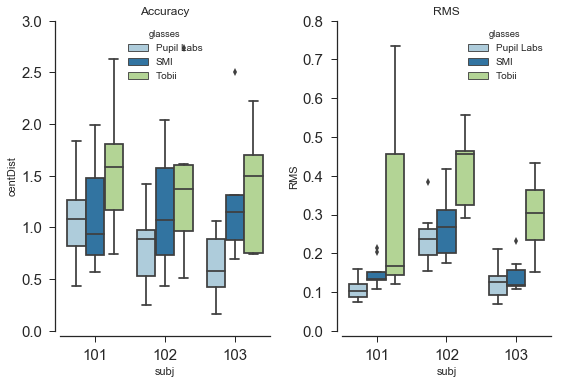

In [12]:
# plot accuracy & RMS
fig, ax = plt.subplots(1,2)

sns.boxplot(x="subj", y="centDist", hue='glasses', ax=ax[0], data=df_byCond, palette="Paired")
sns.despine(offset=5, trim=False)
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,3)

sns.boxplot(x="subj", y="RMS", hue='glasses', ax=ax[1], data=df_byCond, palette="Paired")
sns.despine(offset=5, trim=False)
ax[1].set_title('RMS')
ax[1].set_ylim(0,.8)

plt.tight_layout()

Instead of treating each 'subject' independently, here is a box plot representing all 27 datapoints/glasses (3 subjects, 3 distances, 3 offsets):

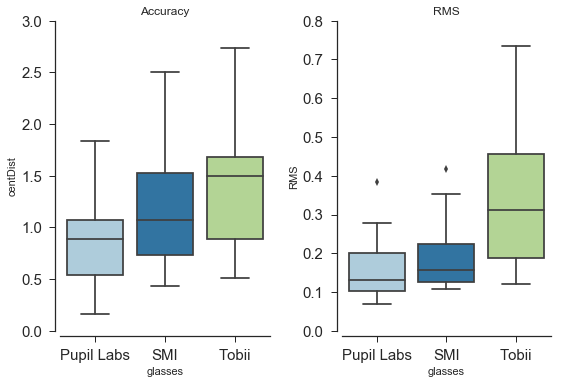

In [13]:
# plot accuracy & RMS
fig, ax = plt.subplots(1,2)

sns.boxplot(x="glasses", y="centDist", ax=ax[0], data=df_byCond, palette="Paired")

sns.despine(offset=5, trim=False)
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,3)

sns.boxplot(x="glasses", y="RMS", ax=ax[1], data=df_byCond, palette="Paired")
sns.despine(offset=5, trim=False)
ax[1].set_title('RMS')
ax[1].set_ylim(0,.8)

plt.tight_layout()

---
# Accuracy and precision as a function of distance

For this analysis, restrict the data to the 0deg offset condition only

In [14]:
df_0deg = df[df.offset=='0deg']
df_0deg.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj,glasses,dist,offset,condition
0,1,15,0.992,872.513,456.424,0.683,48.041,0.113,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
1,2,21,0.996,178.414,736.665,1.135,83.071,0.074,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
2,3,3,0.992,529.483,128.252,0.564,52.494,0.114,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
3,4,13,0.988,537.017,401.570,1.226,69.390,0.123,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
4,5,25,0.992,862.071,709.513,1.481,76.933,0.087,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg


In [15]:
# accuracy by distance model
acc_byDist_md =  smf.mixedlm('centDist ~ glasses + dist', df_0deg, groups=df_0deg['subj']).fit()
print(acc_byDist_md.summary()) 

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: centDist 
No. Observations:   243     Method:             REML     
No. Groups:         3       Scale:              0.3015   
Min. group size:    81      Likelihood:         -209.8577
Max. group size:    81      Converged:          No       
Mean group size:    81.0                                 
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.604    0.327 1.848 0.065 -0.037  1.244
glasses[T.SMI]   0.077    0.086 0.893 0.372 -0.092  0.246
glasses[T.Tobii] 0.588    0.086 6.818 0.000  0.419  0.757
dist[T.2M]       0.518    0.086 6.000 0.000  0.349  0.687
dist[T.3M]       0.201    0.086 2.325 0.020  0.032  0.370
groups RE        0.301                                   



/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2001: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


### plot accuracy and precision as a function of distance at 0deg offset

(0, 0.6)

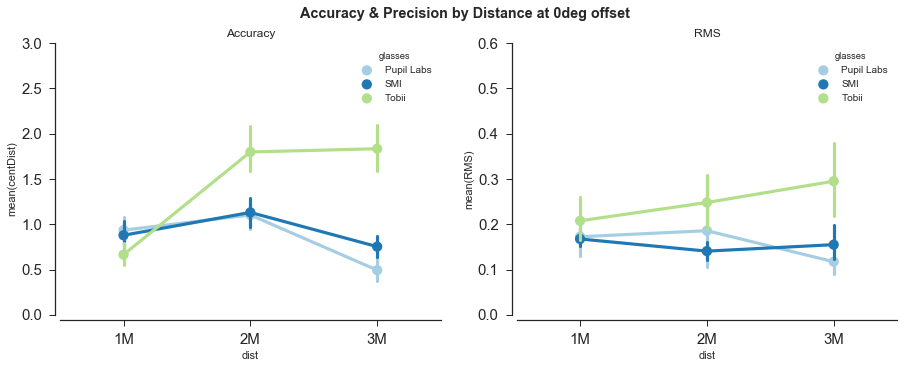

In [16]:
# plot accuracy & RMS
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Accuracy & Precision by Distance at 0deg offset', fontweight='bold')

sns.pointplot(x="dist", y="centDist", ax=ax[0], hue='glasses', 
              data=df_0deg, palette="Paired")

sns.despine(offset=5, trim=False)
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,3)

sns.pointplot(x="dist", y="RMS", ax=ax[1], hue='glasses', 
              data=df_0deg, palette="Paired")
sns.despine(offset=5, trim=False)
ax[1].set_title('RMS')
ax[1].set_ylim(0,.6)

---
# Accuracy and Precision by Distance and Offset


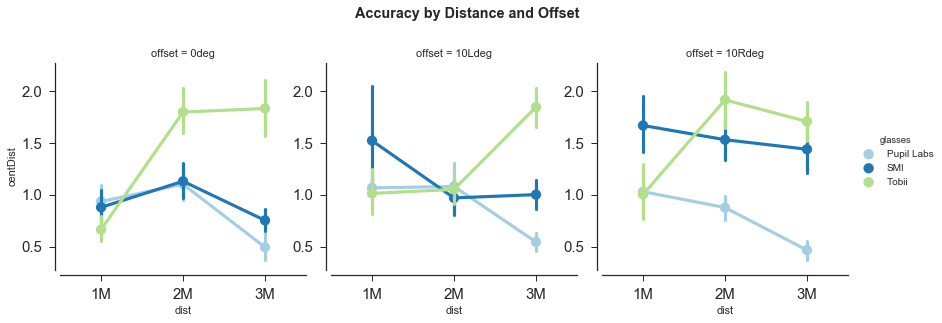

In [17]:
# accuracy plot
sns.factorplot(x="dist", y="centDist", hue='glasses', col="offset",
              data=df, palette="Paired")
sns.despine(offset=5, trim=False)

# add title
plt.gcf().suptitle('Accuracy by Distance and Offset', fontweight='bold', x=.5, y=1.1)

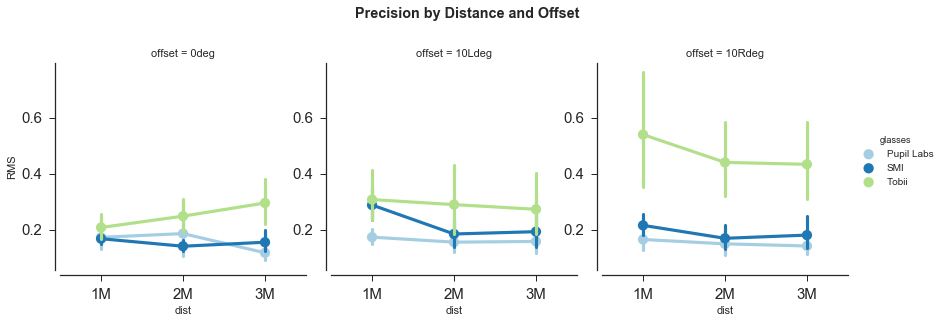

In [18]:
# precision plot
sns.factorplot(x="dist", y="RMS", hue='glasses', col="offset",
              data=df, palette="Paired")
sns.despine(offset=5, trim=False)

# add title
plt.gcf().suptitle('Precision by Distance and Offset', fontweight='bold', x=.5, y=1.1)